In [27]:
import os
import cv2
import sys
import json
import math
import time
import torch
import warnings
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path

from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor



from os.path import join as pjoin
from bop_toolkit_lib import inout
warnings.filterwarnings("ignore")

base_path = os.path.dirname(os.path.abspath("."))
sys.path.append(base_path)

from lib import rendering, network

from dataset import LineMOD_Dataset
from evaluation import utils
from evaluation import config as cfg

# gpu_id = 0
gpu_id = 1

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
os.environ['EGL_DEVICE_ID'] = str(gpu_id)
DEVICE = torch.device('cuda')


datapath = Path(cfg.DATA_PATH)

eval_dataset = LineMOD_Dataset.Dataset(datapath / 'lm')

################################################# MASK-RCNN Segmentation ##################################################################
rcnnIdx_to_lmIds_dict = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:13, 13:14, 14:15}
rcnnIdx_to_lmCats_dict ={0:'Ape', 1:'Benchvice', 2:'Bowl', 3:'Camera', 4:'Can', 5:'Cat', 6:'Cup', 7:'Driller', 
                        8:'Duck', 9:'Eggbox', 10:'Glue', 11:'Holepunch', 12:'Iron', 13:'Lamp', 14:'Phone'}
rcnn_cfg = get_cfg()
rcnn_cfg.INPUT.MASK_FORMAT = 'bitmask'
rcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
rcnn_cfg.DATASETS.TEST = ("lmo_test", )
rcnn_cfg.OUTPUT_DIR = "/home/dingding/Workspace/STN_Inplane_Depth/notebooks/aug_trainer_freeze_backbone_lm_50k_lm_50k"
rcnn_cfg.OUTPUT_DIR = ""
rcnn_cfg.MODEL.WEIGHTS = os.path.abspath(os.path.join(rcnn_cfg.OUTPUT_DIR, 'model_final.pth'))
rcnn_cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(rcnnIdx_to_lmCats_dict)
rcnn_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001 # the predicted category scores
predictor = DefaultPredictor(rcnn_cfg)
################################################# MASK-RCNN Segmentation ##################################################################



cfg.RENDER_WIDTH = eval_dataset.cam_width    # the width of rendered images
cfg.RENDER_HEIGHT = eval_dataset.cam_height  # the height of rendered images

cfg.DATASET_NAME = 'lm'        # dataset name
# cfg.ZOOM_MODE = 'bilinear'
# cfg.RENDER_NUM_VIEWS = 4000
# cfg.ZOOM_DIST_FACTOR  = 0.01   # zooming distance factor relative to object diameter (i.e. zoom_dist = 8 * diameter)


cfg.HEMI_ONLY = True   # only the upper hemishpere is used for LineMOD
# cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
# cfg.RANK_NUM_TOPK = 5  # the ranking number of full 3D orientation 


ckpt_file = pjoin(base_path, 
                'checkpoints', 
                "narvi_maxPool_detach_pose_model_50_121526_11_02-05:39:36_0.0046_0.0198_5.3.pth"
                )
model_net = network.OVE6D().to(DEVICE)

model_net.load_state_dict(torch.load(ckpt_file), strict=True)
model_net.eval()

codebook_saving_dir = pjoin(base_path,'evaluation/object_codebooks',
                            cfg.DATASET_NAME, 
                            'zoom_{}'.format(cfg.ZOOM_DIST_FACTOR), 
                            'views_{}'.format(str(cfg.RENDER_NUM_VIEWS)))


object_codebooks = utils.OVE6D_codebook_generation(codebook_dir=codebook_saving_dir, 
                                                    model_func=model_net,
                                                    dataset=eval_dataset, 
                                                    config=cfg, 
                                                    device=DEVICE)

Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_01_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_02_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_03_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_04_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_05_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_06_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_07_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/lm/zoom_0.01/views_4000/lm_obj_08_views_4000.npy


tensor(5.7924) tensor(nan) tensor(nan)
tensor(5.7924) tensor(0.9915) tensor(3.2387)


torch.Size([5, 480, 640])

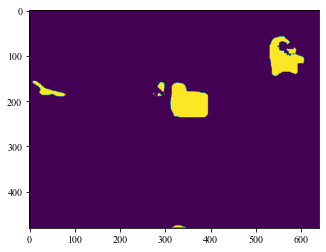

In [91]:
raw_pred_results = list()
icp1_pred_results = list()
icpk_pred_results = list()
raw_pred_runtime = list()
icp1_pred_runtime = list()
icpk_pred_runtime = list()

rcnn_gt_results = dict()
rcnn_pd_results = dict()

test_data_dir = datapath / 'lm' / 'test'          # path to the test dataset of BOP
eval_dir = pjoin(base_path, 'evaluation/bop_pred_results/LM')



obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)

if not os.path.exists(eval_dir):
    os.makedirs(eval_dir)

    
img_read_cost = list()
bg_cost = list()
zoom_cost = list()
rot_cost = list()
tsl_cost = list()

USE_GT_MASK = True
USE_GT_MASK = False

raw_syn_render_cost = list()
raw_selection_cost = list()
raw_postprocess_cost = list()

icp1_refinement_cost = list()
icpk_refinement_cost = list()

icpk_syn_render_cost = list()
icpk_selection_cost = list()
icpk_postprocess_cost = list()

for scene_id in sorted(os.listdir(test_data_dir))[14:]:
    tar_obj_id = int(scene_id)
    # if tar_obj_id not in [3, 7]:  # skip these two objects
    #     continue

    scene_dir = pjoin(test_data_dir, scene_id)
    if not os.path.isdir(scene_dir):
        continue        
    cam_info_file = pjoin(scene_dir, 'scene_camera.json')
    with open(cam_info_file, 'r') as cam_f:
        scene_camera_info = json.load(cam_f)
    
    gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
    with open(gt_pose_file, 'r') as pose_f:
        pose_anno = json.load(pose_f)

    rgb_dir = pjoin(scene_dir, 'rgb')
    depth_dir = pjoin(scene_dir, 'depth')
    mask_dir = os.path.join(scene_dir, 'mask_visib')
    rcnn_runtime = list()
    view_runtime = list()
    for rgb_png in sorted(os.listdir(rgb_dir))[0:]:
        if not rgb_png.endswith('.png'):
            continue
        view_id_str = rgb_png.split('.')[0]
        view_id = int(view_id_str)
        view_timer = time.time()
        
        tar_obj_codebook = object_codebooks[tar_obj_id]
        
        view_cam_info = scene_camera_info[str(view_id)]  # scene camera information        
        depth_file = pjoin(depth_dir, "{:06d}.png".format(view_id))
        view_depth = torch.tensor(np.array(Image.open(depth_file)), dtype=torch.float32) # HxW
        view_depth *= view_cam_info['depth_scale']
        view_depth *= cfg.MODEL_SCALING # convert to meter scale from millimeter scale
        view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...] # 1x3x3
        cam_K = view_camK.to(DEVICE)
        view_depth = view_depth.to(DEVICE)
            
        
        
        view_pose = pose_anno[str(view_id)][0]
        obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(view_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
        obj_gt_t = torch.tensor(view_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING
        
        img_name = "{:06d}.png".format(view_id)
        rgb_file = os.path.join(rgb_dir, img_name)
        pil_img = Image.open(rgb_file)
        rgb_img = np.array(pil_img)
        
        if USE_GT_MASK:
            msk_file = os.path.join(mask_dir, "{:06d}_{:06d}.png".format(view_id, 0))
            tar_obj_masks = torch.tensor(np.array(Image.open(msk_file))).type(torch.bool)
            
            tar_obj_masks = tar_obj_masks[None, ...]
            tar_obj_depths = view_depth[None, ...] * tar_obj_masks.to(DEVICE)
            
            pose_ret = utils.OVE6D_mask_full_pose(model_func=model_net, 
                                                obj_depth=tar_obj_depths,
                                                obj_mask=tar_obj_masks,
                                                obj_codebook=tar_obj_codebook, 
                                                cam_K=cam_K,
                                                config=cfg, 
                                                device=DEVICE,
                                                obj_renderer=obj_renderer)
            raw_pose_R = pose_ret['raw_R']
            raw_pose_t = pose_ret['raw_t']
            
            icp1_pose_R = pose_ret['icp1_R']
            icp1_pose_t = pose_ret['icp1_t']
            
            icpk_pose_R = pose_ret['icpk_R']
            icpk_pose_t = pose_ret['icpk_t']
            
            
        else:
            ###################### read gt mask ##########################
            # target_gt_masks = dict()
            # view_gt_poses = pose_anno[str(view_id)]
            # for ix, gt_obj in enumerate(view_gt_poses):
            #     gt_obj_id = gt_obj['obj_id']
            #     mask_file = os.path.join(mask_dir, "{:06d}_{:06d}.png".format(view_id, ix))
            #     gt_msk = torch.tensor(cv2.imread(mask_file, 0)).type(torch.bool)
            #     target_gt_masks[gt_obj_id] = gt_msk
            #     if gt_obj_id not in rcnn_gt_results:
            #         rcnn_gt_results[gt_obj_id] = 0
            #     rcnn_gt_results[gt_obj_id] += 1
            ###################### read gt mask ##########################    

            ###################### object segmentation ######################
            
            rgb_img = cv2.imread(rgb_file)
            imread_cost = time.time() - view_timer
            img_read_cost.append(imread_cost)

            rcnn_timer = time.time()
            output = predictor(rgb_img)
            rcnn_pred_ids = output["instances"].pred_classes
            rcnn_pred_masks = output["instances"].pred_masks
            rcnn_pred_scores = output["instances"].scores
            # rcnn_pred_bboxes = output["instances"].pred_boxes
            rcnn_cost = time.time() - rcnn_timer
            rcnn_runtime.append(rcnn_cost)
            ###################### object segmentation ######################

            tar_rcnn_d = tar_obj_id - 1
            obj_masks = rcnn_pred_masks # NxHxW
            obj_depths = view_depth[None, ...] * obj_masks
            tar_obj_depths = obj_depths[tar_rcnn_d==rcnn_pred_ids]
            tar_obj_masks = rcnn_pred_masks[tar_rcnn_d==rcnn_pred_ids]
            tar_obj_scores = rcnn_pred_scores[tar_rcnn_d==rcnn_pred_ids]

            if len(tar_obj_scores) > 0:
                mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
                valid_idx = (mask_pixel_count >= 100)
                if valid_idx.sum() == 0:
                    mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
                    valid_idx = mask_visib_ratio >= 0.05

                tar_obj_masks = tar_obj_masks[valid_idx]
                tar_obj_depths = tar_obj_depths[valid_idx]
                tar_obj_scores = tar_obj_scores[valid_idx]

                pose_ret = utils.OVE6D_rcnn_full_pose(model_func=model_net, 
                                                    obj_depths=tar_obj_depths,
                                                    obj_masks=tar_obj_masks,
                                                    obj_rcnn_scores=tar_obj_scores,
                                                    obj_codebook=tar_obj_codebook, 
                                                    cam_K=cam_K,
                                                    config=cfg, 
                                                    device=DEVICE,
                                                    obj_renderer=obj_renderer)
                raw_pose_R = pose_ret['raw_R']
                raw_pose_t = pose_ret['raw_t']

                icp1_pose_R = pose_ret['icp1_R']
                icp1_pose_t = pose_ret['icp1_t']

                icpk_pose_R = pose_ret['icpk_R']
                icpk_pose_t = pose_ret['icpk_t']



        
        
        break # image dir
    break # scene dir
del obj_renderer
    

# obj_gt_R, obj_gt_t
raw_R_err = torch.arccos(torch.trace(raw_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
icp1_R_err = torch.arccos(torch.trace(icp1_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
icpk_R_err = torch.arccos(torch.trace(icpk_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
print(raw_R_err, icp1_R_err, icpk_R_err)

raw_R_err = utils.rotation_error(raw_pose_R, obj_gt_R)
icp1_R_err = utils.rotation_error(icp1_pose_R, obj_gt_R)
icpk_R_err = utils.rotation_error(icpk_pose_R, obj_gt_R)
print(raw_R_err, icp1_R_err, icpk_R_err)


# vis = tar_obj_masks.su
plt.imshow(tar_obj_masks.sum(dim=0).cpu())
tar_obj_masks.shape

In [95]:


def box_2D_shape(points, pose, K):
    canonical_homo_pts = torch.tensor(vert2_to_bbox8(points).T, dtype=torch.float32)
    trans_homo = pose @ canonical_homo_pts
    homo_K = torch.zeros((3, 4), dtype=torch.float32)
    homo_K[:3, :3] = torch.tensor(K, dtype=torch.float32)
    bbox_2D = (homo_K @ trans_homo)
    bbox_2D = (bbox_2D[:2] / bbox_2D[2]).T.type(torch.int32)#.tolist()
    return bbox_2D



def vert2_to_bbox8(corner_pts, homo=True):
    pts = list()
    for i in range(2):
        for j in range(2):
            for k in range(2):
                if homo:
                    pt = [corner_pts[i, 0], corner_pts[j, 1], corner_pts[k, 2], 1.0]
                else:
                    pt = [corner_pts[i, 0], corner_pts[j, 1], corner_pts[k, 2]]
                pts.append(pt)   
    return np.asarray(pts)

def bbox_to_shape(bbox_2D):
    connect_points = [[0, 2, 3, 1, 0], [0, 4, 6, 2], [2, 3, 7, 6], [6, 4, 5, 7], [7, 3, 1, 5]]
    shape = list()
    for plane in connect_points:
        for idx in plane:
            point = (bbox_2D[idx][0], bbox_2D[idx][1])
            shape.append(point)
    return shape


obj_mesh = tar_obj_codebook['obj_mesh']

PD_raw_pose = torch.eye(4, dtype=torch.float32)
PD_raw_pose[:3, 3] = raw_pose_t
PD_raw_pose[:3, :3] = cfg.POSE_TO_BOP(raw_pose_R)


PD_icp1_pose = torch.eye(4, dtype=torch.float32)
PD_icp1_pose[:3, 3] = icp1_pose_t
PD_icp1_pose[:3, :3] = cfg.POSE_TO_BOP(icp1_pose_R)


PD_icpk_pose = torch.eye(4, dtype=torch.float32)
PD_icpk_pose[:3, 3] = icpk_pose_t
PD_icpk_pose[:3, :3] = cfg.POSE_TO_BOP(icpk_pose_R)



# Rxy_pose = torch.eye(4, dtype=torch.float32)
# Rxy_pose[:3, :3] = config.POSE_TO_TLESS(retrieved_codebook_R[ix])
# Rxy_pose[:3, 3] = raw_est_ts[ix]


GT_pose = torch.eye(4, dtype=torch.float32)
GT_pose[:3, :3] = obj_gt_R
GT_pose[:3, 3] = obj_gt_t



corner_pts = obj_mesh.bounds


GT_2D_bbox = box_2D_shape(points=corner_pts, pose=GT_pose, K=cam_K)
PD_raw_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_raw_pose, K=cam_K)
PD_icp1_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_icp1_pose, K=cam_K)
PD_icpk_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_icpk_pose, K=cam_K)

GT_shape = bbox_to_shape(GT_2D_bbox.tolist())
PD_raw_shape = bbox_to_shape(PD_raw_2D_bbox.tolist())
PD_icp1_shape = bbox_to_shape(PD_icp1_2D_bbox.tolist())
PD_icpk_shape = bbox_to_shape(PD_icpk_2D_bbox.tolist())

# Rxy_shape = bbox_to_shape(Rxy_2D_bbox.tolist())


/home/hdd/Dingding/Dataspace/BOP_Dataset/lm/test/000015/rgb/000000.png


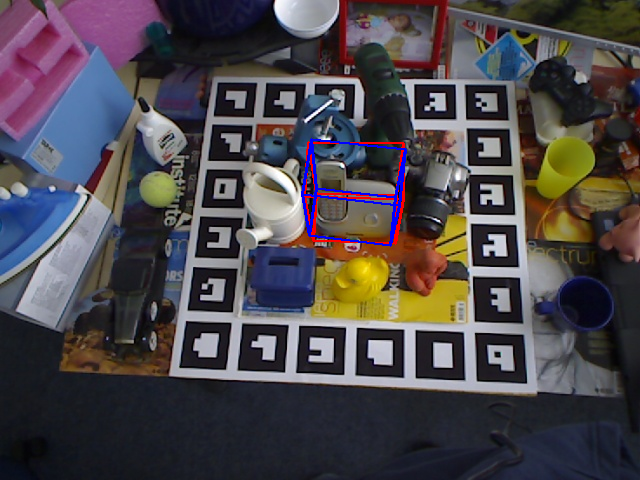

In [96]:
from PIL import ImageDraw, Image

RGB_bbox_img = pil_img.copy()

draw = ImageDraw.Draw(RGB_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # red for GT

draw.line(PD_raw_shape, (0, 0, 255), 3)  # blue

# draw.line(PD_icp1_shape, (0, 255, 0), 3)  # green
# draw.line(PD_icpk_shape, (255, 0, 255), 3)  # cyan

print(rgb_file)
RGB_bbox_img
